## Fase 1. Cargar el Dataset y preparar la base de clientes

In [57]:
import pandas as pd
from datetime import datetime

# 1. Cargar el dataset

df = pd.read_csv(r"C:\UNIVERSIDAD\SEPTIMO SEMESTRE\ANALÍTICA DE DATOS\bank_transactions.csv")

In [58]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB
None


In [59]:
# 2. Eliminar registros sin datos claves
df = df.dropna(subset=['CustomerID','CustomerDOB','CustAccountBalance'])

In [60]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1042802 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1042802 non-null  object 
 1   CustomerID               1042802 non-null  object 
 2   CustomerDOB              1042802 non-null  object 
 3   CustGender               1041765 non-null  object 
 4   CustLocation             1042651 non-null  object 
 5   CustAccountBalance       1042802 non-null  float64
 6   TransactionDate          1042802 non-null  object 
 7   TransactionTime          1042802 non-null  int64  
 8   TransactionAmount (INR)  1042802 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 79.6+ MB
None


In [61]:
# 3. Función personalizada para convertir fechas de 2 dígitos al siglo XX si es necesario
def convertir_fecha(fecha_str):
    try:
        fecha = datetime.strptime(fecha_str, "%d/%m/%y")
        if fecha.year > datetime.now().year:
            fecha = fecha.replace(year=fecha.year - 100)
        return fecha
    except:
        return pd.NaT # Devuelve valor faltante si no puede parsear

# 4. Aplicar función a CustomerDOB
df['CustomerDOB'] = df['CustomerDOB'].apply(convertir_fecha)


In [62]:
# 5. Eliminar registros que no pudieron convertirse correctamente a fecha (errores de formato)
df = df.dropna(subset=['CustomerDOB']) # quitar errores de conversión

In [63]:
# 6. Calcular la edad del cliente en años (año actual - año de nacimiento)
# Calcular la edad como la diferencia entre hoy y la fecha de nacimiento
hoy = pd.to_datetime("today")
df['Edad'] = (hoy - df['CustomerDOB']).dt.days // 365

In [64]:
print(df['CustomerDOB'].head(10))

0   1994-01-10
1   1957-04-04
2   1996-11-26
3   1973-09-14
4   1988-03-24
5   1972-10-08
6   1992-01-26
7   1982-01-27
8   1988-04-19
9   1984-06-22
Name: CustomerDOB, dtype: datetime64[ns]


In [65]:
# 7. Codificar el género: F = 1, M = 0
df['CustGender'] = df['CustGender'].map({'M': 0, 'F': 1})

In [66]:
moda = df['CustGender'].mode()[0]

In [67]:
print(moda)

0.0


In [68]:
# 8. Imputar valores faltantes de género con la moda (valor más frecuente)
df['CustGender'] = df['CustGender'].fillna(df['CustGender'].mode()[0])

In [69]:
# 9. Agrupar por cliente y calcular variables agregadas para el modelo
df_clientes = df.groupby('CustomerID').agg({
    'Edad': 'first',  # Edad no cambia entre transacciones
    #'TransactionID': 'count',  # Total de transacciones realizadas
    'TransactionAmount (INR)': 'mean',  # Monto promedio entre transacciones
    'CustAccountBalance': 'mean',  # Saldo promedio de la cuenta
    'CustGender': 'first'  # Género (asumido constante por cliente)
}).reset_index()


In [70]:
print(df_clientes.head())

  CustomerID  Edad  TransactionAmount (INR)  CustAccountBalance  CustGender
0   C1010011    32                   2553.0           76340.635         1.0
1   C1010012    31                   1499.0           24204.490         0.0
2   C1010014    33                    727.5          100112.950         1.0
3   C1010018    35                     30.0             496.180         1.0
4   C1010024    60                   5000.0           87058.650         0.0


In [71]:
# 10. Renombrar columnas para claridad
df_clientes.columns = ['CustomerID', 'Edad', 'Monto_Promedio', 'Saldo_Promedio', 'Genero']

In [72]:
# 11. Visualizar las priemras gilas del dataset final
print(df_clientes.head())

  CustomerID  Edad  Monto_Promedio  Saldo_Promedio  Genero
0   C1010011    32          2553.0       76340.635     1.0
1   C1010012    31          1499.0       24204.490     0.0
2   C1010014    33           727.5      100112.950     1.0
3   C1010018    35            30.0         496.180     1.0
4   C1010024    60          5000.0       87058.650     0.0


In [73]:
# 12. Validacion de cuantas transacciones tiene cada cliente
print(df['CustomerID'].value_counts().describe())

count    839320.000000
mean          1.174328
std           0.435172
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           6.000000
Name: count, dtype: float64


## Fase 2: Escalamiento y entrenamiento del modelo

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [75]:
# 1. Seleccionar las variables que se usarán para el modelo
X = df_clientes[['Edad', 'Monto_Promedio', 'Saldo_Promedio', 'Genero']]

In [76]:
# 2. Escalar las variables (K-Means es sensible a las diferencias de escala)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [77]:
print(X_scaled)

[[-0.86866704  0.18188422 -0.03753049  1.61548032]
 [-0.98264758  0.00750295 -0.1038497  -0.61901095]
 [-0.7546865  -0.12013951 -0.00729118  1.61548032]
 ...
 [-0.98264758 -0.21965595 -0.12756654 -0.61901095]
 [-1.09662811 -0.23222993 -0.08974097 -0.61901095]
 [ 0.27113834 -0.099045   -0.12577401 -0.61901095]]


In [78]:
type(X_scaled)

numpy.ndarray

In [79]:
# 3. Visualizar Elbow Method para decidir número óptimo de clusters
inercia = []
rango_k = range(2, 10)  # aquí definí que los codos pueden ir de 2 a 10

for k in rango_k:
    modelo = KMeans(n_clusters=k, random_state=42)
    modelo.fit(X_scaled)
    inercia.append(modelo.inertia_)

In [80]:
print(inercia.count)

<built-in method count of list object at 0x000001ECB493A780>


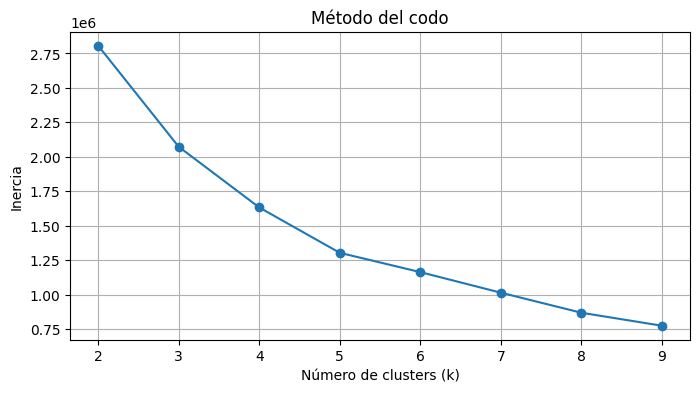

In [81]:
# 4. Graficar curva del codo
plt.figure(figsize=(8, 4))
plt.plot(rango_k, inercia, marker='o')
plt.title('Método del codo')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

### Calculo del Silhouette_Score

In [82]:
from sklearn.utils import resample
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# Tomar una muestra aleatoria de 10,000 filas
X_sample = resample(X_scaled, n_samples=10000, random_state=42)

silhouette_values = []
for k in range(2, 10):
    modelo = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=10000)
    etiquetas = modelo.fit_predict(X_sample)
    score = silhouette_score(X_sample, etiquetas)
    silhouette_values.append(score)
    print(f"k={k} -> silhouette_score: {score:.4f}")

k=2 -> silhouette_score: 0.4249
k=3 -> silhouette_score: 0.5730
k=4 -> silhouette_score: 0.5757
k=5 -> silhouette_score: 0.4566
k=6 -> silhouette_score: 0.3742
k=7 -> silhouette_score: 0.4597
k=8 -> silhouette_score: 0.4077
k=9 -> silhouette_score: 0.4106


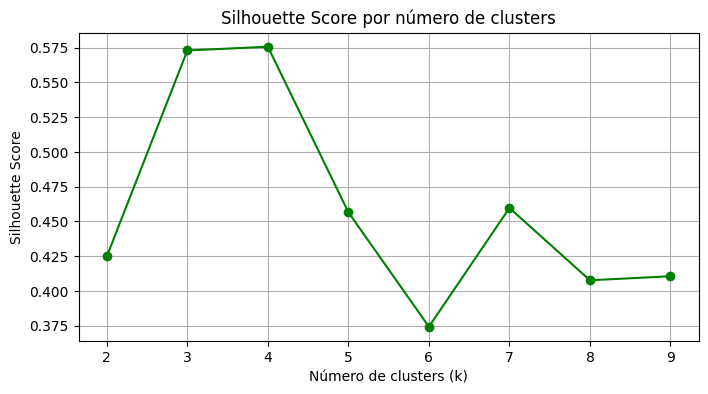

In [83]:
# Graficar resultado
plt.figure(figsize=(8, 4))
plt.plot(rango_k, silhouette_values, marker='o', color='green')
plt.title('Silhouette Score por número de clusters')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


### Codigo de entrenamiento final y guardado del modelo

In [84]:
from sklearn.cluster import KMeans
import joblib  # para guardar modelos
import os
import numpy as np


# 1. Elegir el valor óptimo de k (basado en Elbow y Silhouette)
k_optimo = 4  # <-- cámbialo si tu análisis da otro mejor valor

# 2. Entrenar el modelo final
modelo_final = KMeans(n_clusters=k_optimo, random_state=42)
modelo_final.fit(X_scaled)

# Añadir columna con el cluster
df_clientes['Cluster'] = modelo_final.predict(X_scaled)

# 3. Crear carpeta de salida si no existe
os.makedirs("modelo_final", exist_ok=True)

# 4. Guardar el modelo entrenado
joblib.dump(modelo_final, "modelo_final/modelo_kmeans.pkl")

# 5. Guardar el escalador
joblib.dump(scaler, "modelo_final/escalador.pkl")

# 6. Calcular y guardar las distancias máximas por cluster

distancias_maximas = []
for cluster in range(modelo_final.n_clusters):
    centroide = modelo_final.cluster_centers_[cluster]
    distancias = np.linalg.norm(X_scaled[modelo_final.labels_ == cluster] - centroide, axis=1)
    distancias_maximas.append(distancias.max())

distancias_maximas = np.array(distancias_maximas)
np.save("modelo_final/distancias_maximas.npy", distancias_maximas)


print("✅ Modelo, escalador y distancias máximas guardados correctamente.")

✅ Modelo, escalador y distancias máximas guardados correctamente.


#### Resumen del cluster

In [85]:
print(df_clientes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839320 entries, 0 to 839319
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   CustomerID      839320 non-null  object 
 1   Edad            839320 non-null  int64  
 2   Monto_Promedio  839320 non-null  float64
 3   Saldo_Promedio  839320 non-null  float64
 4   Genero          839320 non-null  float64
 5   Cluster         839320 non-null  int32  
dtypes: float64(3), int32(1), int64(1), object(1)
memory usage: 35.2+ MB
None


In [86]:
resumen_cluster = df_clientes.groupby('Cluster').agg({
    'Edad': 'mean',
    'Monto_Promedio': 'mean',
    'Saldo_Promedio': 'mean',
    'Genero': lambda x: x.mode()[0] if not x.mode().empty else 'No definido'
}).reset_index()

resumen_cluster.columns = ['Cluster', 'Edad promedio', 'Monto Promedio', 'Saldo promedio', 'Género más común']
resumen_cluster = resumen_cluster.round(2)

print(resumen_cluster)


   Cluster  Edad promedio  Monto Promedio  Saldo promedio  Género más común
0        0          57.15         4160.27       324639.64               0.0
1        1          37.27         1302.53        75879.38               1.0
2        2          37.08          972.33        63535.05               0.0
3        3          66.24        11321.52     48370735.07               0.0


In [87]:
print(df_clientes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839320 entries, 0 to 839319
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   CustomerID      839320 non-null  object 
 1   Edad            839320 non-null  int64  
 2   Monto_Promedio  839320 non-null  float64
 3   Saldo_Promedio  839320 non-null  float64
 4   Genero          839320 non-null  float64
 5   Cluster         839320 non-null  int32  
dtypes: float64(3), int32(1), int64(1), object(1)
memory usage: 35.2+ MB
None


### Creacion y asignacion de segmentos segun caracteristicas de resumen_cluster

In [88]:
# Diccionario de descripción de segmentos
segmentos = {
    0: "Adultos mayores con alto saldo y gasto medio",
    1: "Clientes maduros con saldo medio y bajo gasto",
    2: "Adultos jóvenes de saldo medio-bajo",
    3: "Clientes premium con altísimo saldo y gasto",
    4: "Jóvenes con bajo saldo y bajo consumo"
}

# Asignar segmentos usando la columna 'Cluster'
df_clientes['Segmento'] = df_clientes['Cluster'].map(segmentos)

# Ver ejemplo
print(df_clientes[['Cluster', 'Edad', 'Monto_Promedio', 'Saldo_Promedio', 'Genero', 'Segmento']].head())


   Cluster  Edad  Monto_Promedio  Saldo_Promedio  Genero  \
0        1    32          2553.0       76340.635     1.0   
1        2    31          1499.0       24204.490     0.0   
2        1    33           727.5      100112.950     1.0   
3        1    35            30.0         496.180     1.0   
4        0    60          5000.0       87058.650     0.0   

                                        Segmento  
0  Clientes maduros con saldo medio y bajo gasto  
1            Adultos jóvenes de saldo medio-bajo  
2  Clientes maduros con saldo medio y bajo gasto  
3  Clientes maduros con saldo medio y bajo gasto  
4   Adultos mayores con alto saldo y gasto medio  


In [89]:
print(df_clientes.head())

  CustomerID  Edad  Monto_Promedio  Saldo_Promedio  Genero  Cluster  \
0   C1010011    32          2553.0       76340.635     1.0        1   
1   C1010012    31          1499.0       24204.490     0.0        2   
2   C1010014    33           727.5      100112.950     1.0        1   
3   C1010018    35            30.0         496.180     1.0        1   
4   C1010024    60          5000.0       87058.650     0.0        0   

                                        Segmento  
0  Clientes maduros con saldo medio y bajo gasto  
1            Adultos jóvenes de saldo medio-bajo  
2  Clientes maduros con saldo medio y bajo gasto  
3  Clientes maduros con saldo medio y bajo gasto  
4   Adultos mayores con alto saldo y gasto medio  


### Graficos para la revision

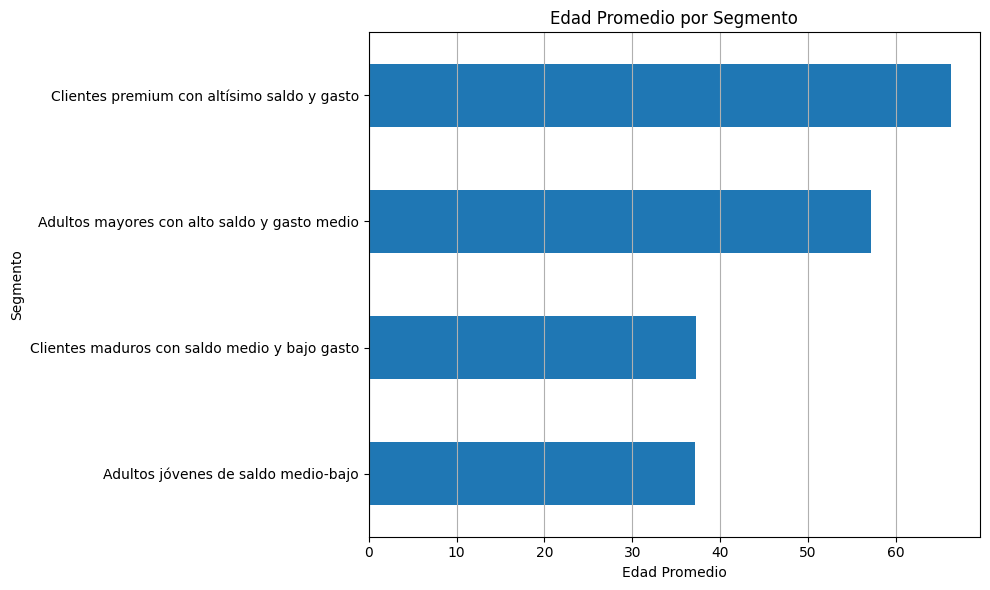

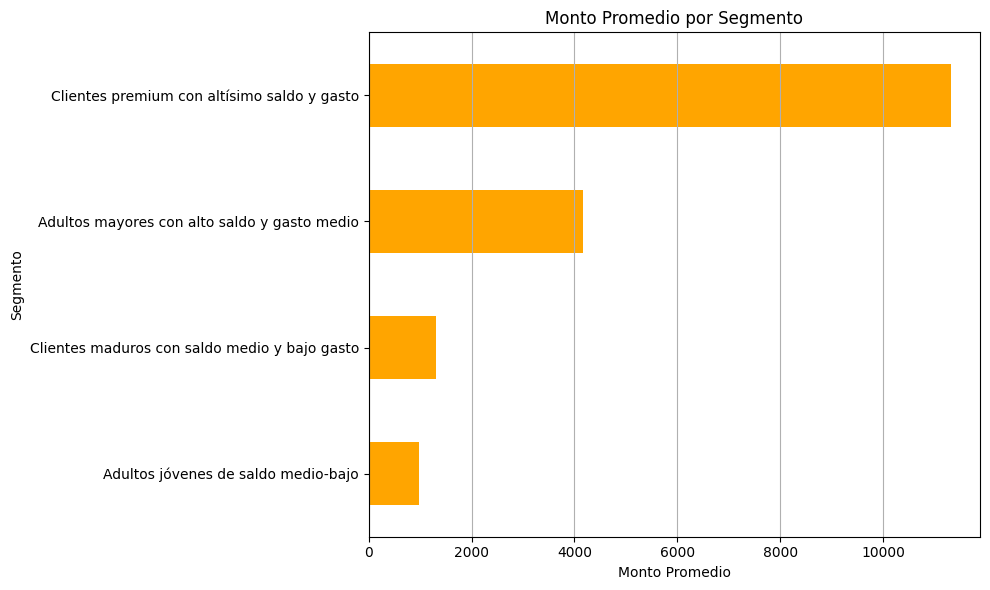

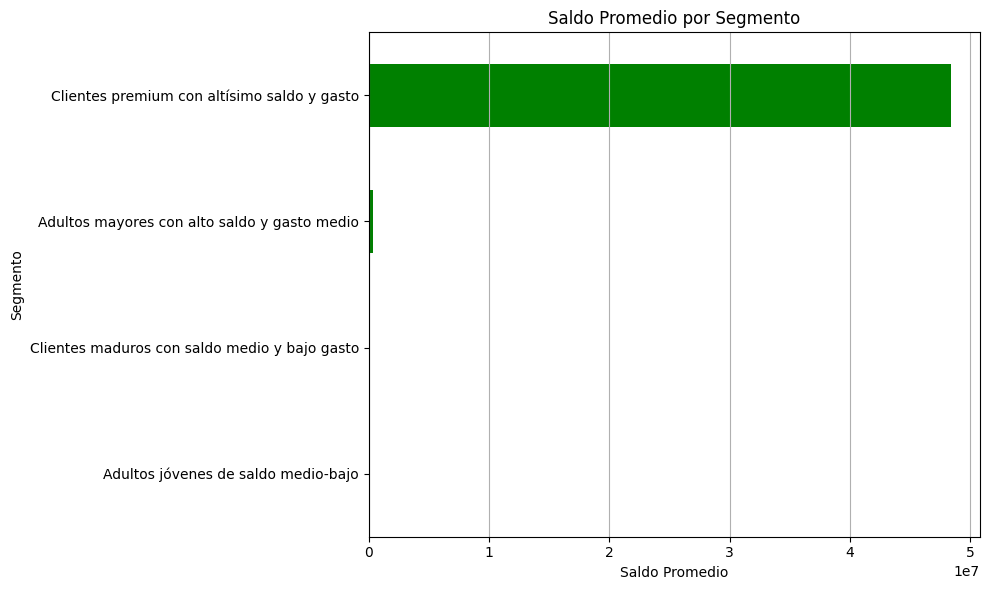

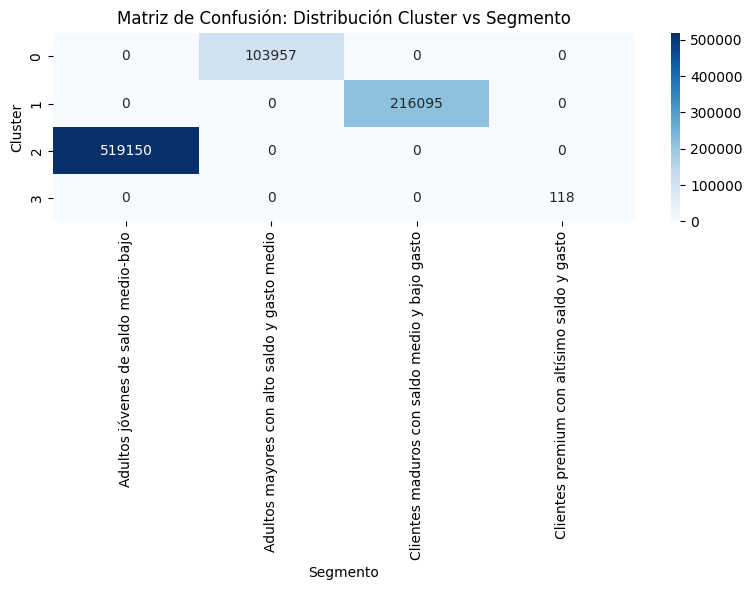

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que los nombres de las columnas no tengan espacios
df_clientes.columns = [col.replace(" ", "_") for col in df_clientes.columns]

# --------------------- Gráficos individuales por Segmento ---------------------

# 1. Edad Promedio por Segmento
plt.figure(figsize=(10, 6))
df_clientes.groupby('Segmento')['Edad'].mean().sort_values().plot(kind='barh')
plt.title('Edad Promedio por Segmento')
plt.xlabel('Edad Promedio')
plt.ylabel('Segmento')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# 2. Monto Promedio por Segmento
plt.figure(figsize=(10, 6))
df_clientes.groupby('Segmento')['Monto_Promedio'].mean().sort_values().plot(kind='barh', color='orange')
plt.title('Monto Promedio por Segmento')
plt.xlabel('Monto Promedio')
plt.ylabel('Segmento')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# 3. Saldo Promedio por Segmento
plt.figure(figsize=(10, 6))
df_clientes.groupby('Segmento')['Saldo_Promedio'].mean().sort_values().plot(kind='barh', color='green')
plt.title('Saldo Promedio por Segmento')
plt.xlabel('Saldo Promedio')
plt.ylabel('Segmento')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# --------------------- Matriz de Confusión tipo Heatmap ---------------------

# Generar matriz de conteo entre Cluster y Segmento
confusion_seg = pd.crosstab(df_clientes['Cluster'], df_clientes['Segmento'])

# Graficar matriz con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_seg, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión: Distribución Cluster vs Segmento')
plt.ylabel('Cluster')
plt.xlabel('Segmento')
plt.tight_layout()
plt.show()


## Probar el modelo como funcion

In [91]:
import numpy as np
import pandas as pd
import joblib

# Cargar el modelo y el escalador previamente guardados
modelo_kmeans = joblib.load("modelo_final/modelo_kmeans.pkl")
scaler = joblib.load("modelo_final/escalador.pkl")

# Diccionario de segmentos
segmentos = {
    0: "Adultos mayores con alto saldo y gasto medio",
    1: "Clientes maduros con saldo medio y bajo gasto",
    2: "Adultos jóvenes de saldo medio-bajo",
    3: "Clientes premium con altísimo saldo y gasto",
    4: "Jóvenes con bajo saldo y bajo consumo"
}
def predecir_segmento(edad, genero, monto_promedio, saldo_promedio):
    # Crear DataFrame con los datos nuevos (el orden es importante)
    datos_nuevos = pd.DataFrame([[edad, monto_promedio, saldo_promedio, genero]],
                                columns=['Edad', 'Monto_Promedio', 'Saldo_Promedio', 'Genero'])
    
    # Escalar los datos nuevos
    datos_nuevos_scaled = scaler.transform(datos_nuevos)
    
    # Predecir el cluster
    cluster = modelo_kmeans.predict(datos_nuevos_scaled)[0]
    
    # Obtener la descripción del segmento
    segmento = segmentos.get(cluster, "Desconocido")
    
    # Calcular confianza: distancia al centroide vs. máxima distancia en ese cluster
    centroide = modelo_kmeans.cluster_centers_[cluster]
    distancia = np.linalg.norm(datos_nuevos_scaled - centroide)
    # Distancias de todos los puntos de ese cluster al centroide
    X_scaled = scaler.transform(X)  # X ya está definida en tu notebook
    distancias_cluster = np.linalg.norm(X_scaled[modelo_kmeans.labels_ == cluster] - centroide, axis=1)
    distancia_max = distancias_cluster.max()
    confianza = 1 - (distancia / distancia_max) if distancia_max > 0 else 1.0
    confianza = max(0, min(confianza, 1))  # Limita entre 0 y 1
    confianza = confianza * 100  # porcentaje

    return cluster, segmento, confianza

In [92]:
cluster, segmento, confianza = predecir_segmento(35, 1, 1500, 30000)
print(f"✅ Segmento asignado: {segmento} (Cluster {cluster}) con confianza {confianza:.1f}%")

✅ Segmento asignado: Clientes maduros con saldo medio y bajo gasto (Cluster 1) con confianza 98.1%


In [93]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [95]:
# Si no tienes tabulate, instálalo con: pip install tabulate
from tabulate import tabulate
import random

# Genera 50 ejemplos variados
ejemplos = [
    # Cluster 0: Adultos jóvenes de saldo medio-bajo
    (36, 0, 500, 50000),
    (38, 1, 600, 52000),
    (37, 0, 550, 48000),
    (35, 1, 700, 53000),
    (39, 0, 650, 51000),
    (36, 1, 500, 49500),
    (38, 0, 600, 50500),
    (37, 1, 550, 52000),
    (35, 0, 700, 48000),
    (39, 1, 650, 53000),

    # Cluster 1: Adultos mayores con alto saldo y gasto medio
    (55, 0, 2000, 200000),
    (54, 1, 2100, 210000),
    (56, 0, 1900, 195000),
    (57, 1, 2200, 205000),
    (53, 0, 2050, 198000),
    (55, 1, 2000, 202000),
    (54, 0, 2100, 208000),
    (56, 1, 1900, 200000),
    (57, 0, 2200, 210000),
    (53, 1, 2050, 199000),

    # Cluster 2: Clientes maduros con saldo medio y bajo gasto
    (37, 0, 1000, 100000),
    (38, 1, 1100, 105000),
    (36, 0, 950, 98000),
    (39, 1, 1200, 102000),
    (37, 0, 1050, 99000),
    (38, 1, 1000, 101000),
    (36, 0, 1100, 103000),
    (39, 1, 950, 97000),
    (37, 0, 1200, 104000),
    (38, 1, 1050, 99000),

    # Cluster 3: Clientes premium con altísimo saldo y gasto
    (66, 0, 9000, 48000000),
    (65, 1, 9500, 49000000),
    (67, 0, 8500, 47000000),
    (68, 1, 10000, 49500000),
    (66, 0, 9200, 48200000),
    (65, 1, 9000, 48800000),
    (67, 0, 9500, 49200000),
    (68, 1, 8500, 47000000),
    (66, 0, 10000, 49500000),
    (65, 1, 9200, 48200000),

    # Cluster 4: Jóvenes con bajo saldo y bajo consumo
    (46, 0, 70000, 500000),
    (45, 1, 68000, 520000),
    (47, 0, 72000, 480000),
    (44, 1, 69000, 530000),
    (48, 0, 71000, 510000),
    (46, 1, 70000, 495000),
    (45, 0, 68000, 505000),
    (47, 1, 72000, 520000),
    (44, 0, 69000, 480000),
    (48, 1, 71000, 530000),
]

tabla = []
for edad, genero, monto, saldo in ejemplos:
    cluster, segmento, confianza = predecir_segmento(edad, genero, monto, saldo)
    tabla.append([
    edad,
    "Masculino" if genero == 0 else "Femenino",
    monto,
    saldo,
    cluster,
    segmento,
    f"{confianza:.1f}%"
])

print(tabulate(
    tabla,
    headers=["Edad", "Género", "Monto Promedio", "Saldo Promedio", "Cluster", "Segmento", "Confianza"],
    tablefmt="github"
))

|   Edad | Género    |   Monto Promedio |   Saldo Promedio |   Cluster | Segmento                                      | Confianza   |
|--------|-----------|------------------|------------------|-----------|-----------------------------------------------|-------------|
|     36 | Masculino |              500 |            50000 |         2 | Adultos jóvenes de saldo medio-bajo           | 98.5%       |
|     38 | Femenino  |              600 |            52000 |         1 | Clientes maduros con saldo medio y bajo gasto | 99.0%       |
|     37 | Masculino |              550 |            48000 |         2 | Adultos jóvenes de saldo medio-bajo           | 99.3%       |
|     35 | Femenino  |              700 |            53000 |         1 | Clientes maduros con saldo medio y bajo gasto | 98.0%       |
|     39 | Masculino |              650 |            51000 |         2 | Adultos jóvenes de saldo medio-bajo           | 97.7%       |
|     36 | Femenino  |              500 |            49